# Prerequisite


In [1]:
!nvidia-smi

Thu Jul  8 15:41:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls
%cd '/content/drive/My Drive/Colab_Notebooks/Face recognization'
!ls

drive  sample_data
/content/drive/My Drive/Colab_Notebooks/Face recognization
aedl_embedding.npz  facenet_keras.h5	  known
aedl.npz	    Face_recognize.ipynb  Test


In [4]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 4.3MB/s 


In [5]:
from keras.models import load_model
import tensorflow as tf
from tensorflow import convert_to_tensor
import mtcnn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from numpy import asarray, savez_compressed, load, expand_dims
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from random import choice

In [6]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# Data-processing

In [ ]:
# from numpy import expand_dims
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import ImageDataGenerator
# from matplotlib import pyplot

# pyplot.show()
# def brightness_image(img):
#   image_convert = []
#   # convert to numpy array
#   data = img_to_array(img)
#   # expand dimension to one sample
#   samples = expand_dims(data, 0)
#   # create image data augmentation generator
#   datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
#   # prepare iterator
#   it = datagen.flow(samples, batch_size=1)
#   # generate samples and plot
#   for i in range(9):
# 	  # define subplot
# 	  pyplot.subplot(330 + 1 + i)
# 	  # generate batch of images
# 	  batch = it.next()
# 	  # convert to unsigned integers for viewing
# 	  image = batch[0].astype('uint8')
# 	  image_convert.append(image)
#   return image_convert

In [7]:
detector = MTCNN()

def crop_face_x(pixels,results):
  # pixels: numpy array
  pixels = asarray(pixels)
  x1, y1, w, h = results[0]['box']
  x1 = x1 - w*0.1 if x1 - w*0.1 > 0 else 0
  y1 = y1 - h*0.1 if y1 - h*0.1 > 0 else 0
  x2 = x1 + w*1.2 if x1 + w*1.2 < pixels.shape[1] else pixels.shape[1]
  y2 = y1 + h*1.2 if y1 + w*1.2 < pixels.shape[0] else pixels.shape[0]
  
  face = pixels[int(y1):int(y2), int(x1):int(x2)]
  return face
def face_extract (filename, required_size=(160,160)):
  image = Image.open(filename)
  # converted_images = brightness_image(base_image)
  # converted_images.append(base_image)

  # for image in converted_images:
    #in case of 4th channel or BW image
  image = image.convert('RGB')

  #convert to nparray and 
  pixels = asarray(image)
  pixels_flip = np.array(image.transpose(method=Image.FLIP_LEFT_RIGHT))
  pixels_top = np.array(image.transpose(method=Image.FLIP_TOP_BOTTOM))
  pixels_rotate_180 = np.array(image.transpose(method=Image.ROTATE_180))
  pixels_rotate_90 = np.array(image.transpose(method=Image.ROTATE_90))
  pixels_rotate_270 = np.array(image.transpose(method=Image.ROTATE_270))
  pixels_transpose = np.array(image.transpose(method=Image.TRANSPOSE))
  pixels_transverse = np.array(image.transpose(method=Image.TRANSVERSE))

  results = detector.detect_faces(pixels)
  results_flip = detector.detect_faces(pixels_flip)
  results_top = detector.detect_faces(pixels_top)
  results_180 = detector.detect_faces(pixels_rotate_180)
  results_90 = detector.detect_faces(pixels_rotate_90)
  results_270 = detector.detect_faces(pixels_rotate_270)
  results_transpose = detector.detect_faces(pixels_transpose)
  results_transverse = detector.detect_faces(pixels_transverse)

  # crop face based on box and box_flip, append each obtained face to face_array
  face_array = []
  if results:
    face = crop_face_x(pixels,results)
    # resize and append face to face_array
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array.append(asarray(image))
    
  if results_flip:
    face_flip = crop_face_x(pixels_flip,results_flip)
    # resize and append face_flip to face_array  
    image = Image.fromarray(face_flip)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_top:
    face_top = crop_face_x(pixels_top,results_top)
    # resize and append face_flip to face_array  
    image = Image.fromarray(face_top)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_180:
    face_180 = crop_face_x(pixels_rotate_180,results_180)
    # resize and append face_flip to face_array  
    image = Image.fromarray(face_180)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_90:
    face_90 = crop_face_x(pixels_rotate_90,results_90)
    # resize and append face_flip to face_array  
    image = Image.fromarray(face_90)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_270:
    face_270 = crop_face_x(pixels_rotate_270,results_270)
    # resize and append face_flip to face_array  
    image = Image.fromarray(face_270)
    image = image.resize(required_size)
    face_array.append(asarray(image))
  
  if results_transpose:
    face_transpose = crop_face_x(pixels_transpose,results_transpose)
    # resize and append face_flip to face_array  
    image = Image.fromarray(face_transpose)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  if results_transverse:
    face_transverse = crop_face_x(pixels_transverse,results_transverse)
    # resize and append face_flip to face_array  
    image = Image.fromarray(face_transverse)
    image = image.resize(required_size)
    face_array.append(asarray(image))

  return face_array

In [8]:
NoneType = type(None)

In [9]:
def load_faces(dir):
  faces = list()
  for filename in listdir(dir):
    path = dir+filename
    face = face_extract(path)
    #  if not isinstance(faces, NoneType):
    faces.extend(face)

  return faces

In [10]:
#load faces and label
def load_data(dir):
  X,y = list(),list()
  for subdir in listdir(dir):
    path = dir + subdir + '/'
    if not isdir(path):
      continue
    faces = load_faces(path)
    #create labels
    labels = [subdir for _ in range(len(faces))]
    #progress tracker
    print('>>loaded {} examples from class: {}'.format(len(faces), subdir))
    X.extend(faces)
    y.extend(labels)
  return asarray(X), asarray(y)

In [11]:
def do_embedding(face_pixels, model):
  #preprocess, standardizing
  face_pixels = face_pixels.astype('float32')
  fmean, fstd = face_pixels.mean(), face_pixels.std()
  face_pixels = (face_pixels-fmean)/fstd
  samples = expand_dims(face_pixels, axis=0) #?
  y_hat = model.predict(samples)             #?
  embedding = y_hat[0]                       #?

  return embedding


#   20 - 100 => mean = (max+min)/2 = 60, std = (max - min)/2 = 40
# standardization
#   -1 -> 1
#   minus mean => -40 -> 40
#   / stad => -1 -> 1 

In [12]:
train_folder = 'known/'
X, y = load_data(train_folder)
print(X.shape, y.shape)

>>loaded 238 examples from class: Vũ 
>>loaded 183 examples from class: Luc
>>loaded 237 examples from class: Son
>>loaded 192 examples from class: Giap Van
(850, 160, 160, 3) (850,)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
savez_compressed('aedl.npz', X_train, y_train, X_val, y_val)

In [15]:
data = load('aedl.npz', allow_pickle=True)
X_train, y_train, X_val, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Loaded:  (680, 160, 160, 3) (680,) (170, 160, 160, 3) (170,)


In [16]:
#Load facenet model
model_facenet = load_model('facenet_keras.h5', compile = False)
print('Model loaded')

Model loaded


In [17]:
# model network
model_facenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [18]:
X_train_new = list()
for face_pixels in X_train:
  embedding = do_embedding(face_pixels, model_facenet)
  X_train_new.append(embedding)

X_train_new = asarray(X_train_new)
print(X_train_new.shape)

Cause: could not parse the source code of <function <lambda> at 0x7f0013495200>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f0013495200>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f00133ba950>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f00133ba950>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f00133ba9e0>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could no

In [20]:
X_val_new = list()
for face_pixels in X_val:
  embedding = do_embedding(face_pixels, model_facenet)
  X_val_new.append(embedding)

X_val_new = asarray(X_val_new)
print(X_val_new.shape)

(170, 128)


In [21]:
savez_compressed('aedl_embedding.npz', X_train_new, y_train, X_val_new, y_val)

In [22]:
data = load('aedl_embedding.npz')
X_train, y_train, X_val, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, val=%d' % (X_train.shape[0], X_val.shape[0]))

Dataset: train=680, val=170


In [23]:
#normalize input vector X_train and X_val
#defining normalization method
in_encoder = Normalizer(norm='l2') 
#Scale input vectors individually to unit norm (vector length).
#normalizing
X_train = in_encoder.transform(X_train)
X_val = in_encoder.transform(X_val)
# print(X_train)
# print(X_val)

In [24]:
  out_encoder = LabelEncoder()
  out_encoder.fit(y_train)
  y_train = out_encoder.transform(y_train)
  print(y_train)
  y_val = out_encoder.transform(y_val) #may be no need for this as this is only used for indicating the expected result?
  print(y_val)

[1 1 1 3 3 2 3 3 2 0 0 2 1 0 2 2 0 2 1 3 3 1 0 1 1 0 1 1 3 2 1 2 3 0 2 2 1
 0 3 2 2 2 1 1 3 3 2 0 2 0 2 0 0 1 1 0 0 3 0 3 2 2 0 3 3 2 3 3 1 3 2 1 1 2
 1 3 3 3 3 3 2 3 0 2 2 3 0 2 3 3 3 2 2 3 2 0 0 3 3 3 1 1 3 2 2 2 3 2 3 1 3
 0 0 2 3 1 0 1 3 1 0 2 1 1 2 2 2 3 2 2 3 3 2 1 1 2 2 3 1 2 3 2 2 2 1 2 2 3
 2 0 3 1 2 0 3 3 2 2 3 3 1 3 0 3 0 0 0 2 2 3 3 0 3 3 1 3 0 2 0 0 3 0 2 3 2
 0 2 1 2 1 2 3 3 1 1 1 2 1 3 0 1 1 1 0 3 1 3 1 3 0 0 0 2 1 0 3 3 3 2 0 2 1
 3 0 2 3 3 2 2 1 3 2 3 1 2 2 3 3 0 3 3 0 1 1 3 0 2 0 1 2 3 1 0 3 3 2 2 2 1
 1 2 3 2 2 0 2 1 1 2 1 2 1 0 3 1 1 0 1 3 0 0 3 3 0 2 3 2 2 0 0 2 3 1 2 3 0
 3 3 0 0 3 2 3 1 2 0 2 1 1 0 3 2 1 2 3 1 1 1 3 3 0 1 1 0 3 1 1 1 1 3 2 3 2
 3 3 1 1 0 1 2 1 2 0 0 3 1 2 3 3 1 1 2 0 3 3 2 3 1 2 2 2 2 2 2 0 3 0 3 2 3
 3 2 3 0 2 0 2 1 0 3 3 0 2 1 3 3 0 1 2 0 0 2 3 0 0 2 0 0 0 3 2 3 2 2 0 3 3
 2 3 2 1 3 3 3 1 0 3 0 2 3 0 3 2 1 1 0 2 2 0 1 1 1 3 0 0 2 2 3 3 2 0 2 1 2
 1 3 3 0 2 3 0 3 2 1 1 1 3 3 3 2 1 1 0 3 1 0 0 0 3 0 2 0 2 0 2 1 0 2 1 0 2
 2 3 3 0 2 1 3 0 1 2 1 0 

# Training


In [25]:
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import ensemble

In [26]:
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=13)

In [27]:
model_SVC = SVC(kernel = 'linear', probability=True, tol=1e-3, cache_size=200, max_iter=-1)
model_Linear = linear_model.LogisticRegression(penalty='l2', tol=1e-4, solver='liblinear')
# model_RandomForest = ensemble.RandomForestClassifier()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=13)

In [28]:
model = model_RandomForest
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.05, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
#     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
#     verbose=False)

In [ ]:
# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='auto', n_jobs=None, penalty='l2',
#                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
#                    warm_start=False)

In [ ]:
# RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                        criterion='gini', max_depth=None, max_features='auto',
#                        max_leaf_nodes=None, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=100,
#                        n_jobs=None, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)

In [29]:
model_SVC.fit(X_train, y_train)
model_Linear.fit(X_train, y_train)
model_RandomForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.05, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
model = model_SVC

y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)
score_train = accuracy_score(y_train, y_hat_train)
score_val = accuracy_score(y_val, y_hat_val)
print('Support Vector Classification: Accuracy: train=%.3f, val=%.3f'%(score_train, score_val))

model = model_Linear

y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)
score_train = accuracy_score(y_train, y_hat_train)
score_val = accuracy_score(y_val, y_hat_val)
print('Logistic Regression Accuracy: train=%.3f, val=%.3f'%(score_train, score_val))

model = model_RandomForest

y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)
score_train = accuracy_score(y_train, y_hat_train)
score_val = accuracy_score(y_val, y_hat_val)
print('Random Forest Classification: Accuracy: train=%.3f, val=%.3f'%(score_train, score_val))


Support Vector Classification: Accuracy: train=0.803, val=0.753
Logistic Regression Accuracy: train=0.790, val=0.753
Random Forest Classification: Accuracy: train=0.566, val=0.541


In [31]:
# Result of:
# + SVC model: Accuracy: train=0.993, val=0.972
# + LogisticRegression model: Accuracy: train=0.972, val=0.972
# + RandomForest model: Accuracy: train=1.000, val=0.972

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

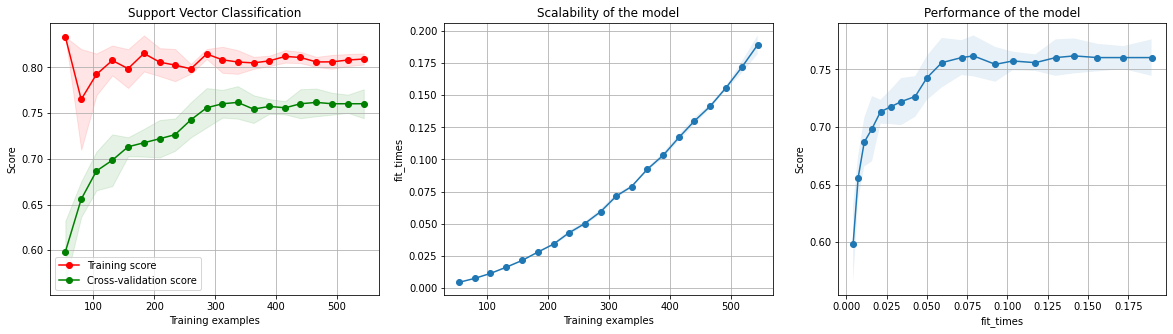

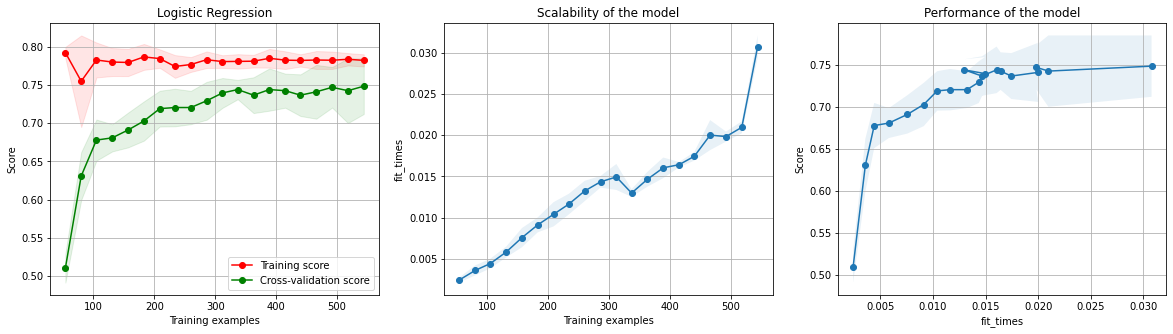

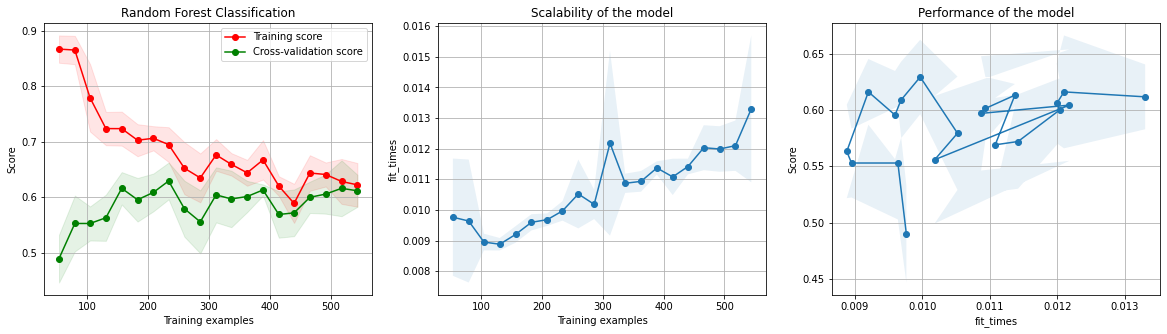

In [32]:
title="SVC"
plot_learning_curve(estimator=model_SVC, title="Support Vector Classification", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20))
title="Lineaar"
plot_learning_curve(estimator=model_Linear, title="Logistic Regression", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20))
title="RF"
plot_learning_curve(estimator=model_RandomForest, title="Random Forest Classification", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20))

In [33]:
train_sizes=np.linspace(0.2, 1.0, 17)
from time import time

time: 1.26507
time: 0.84738
time: 1.81540


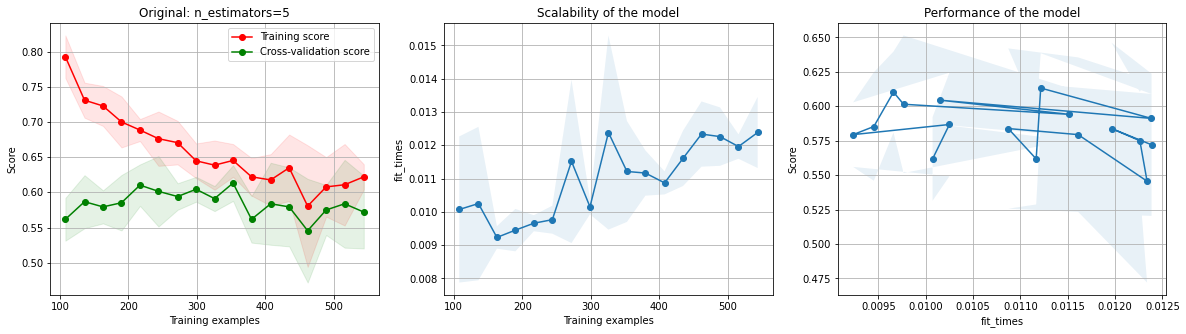

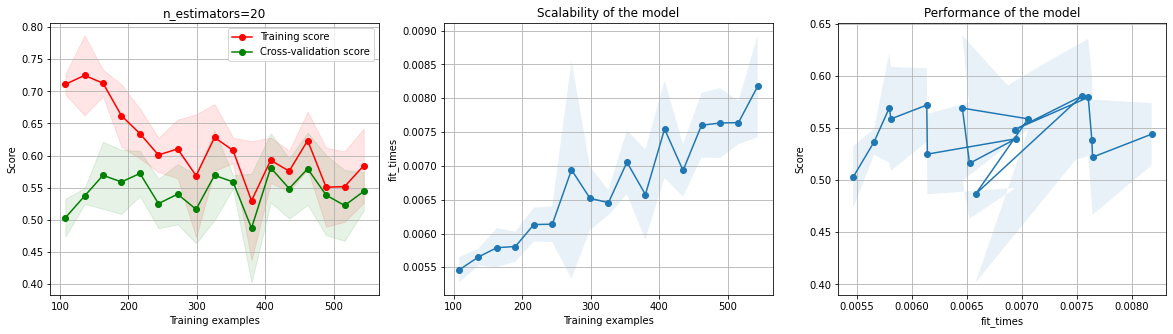

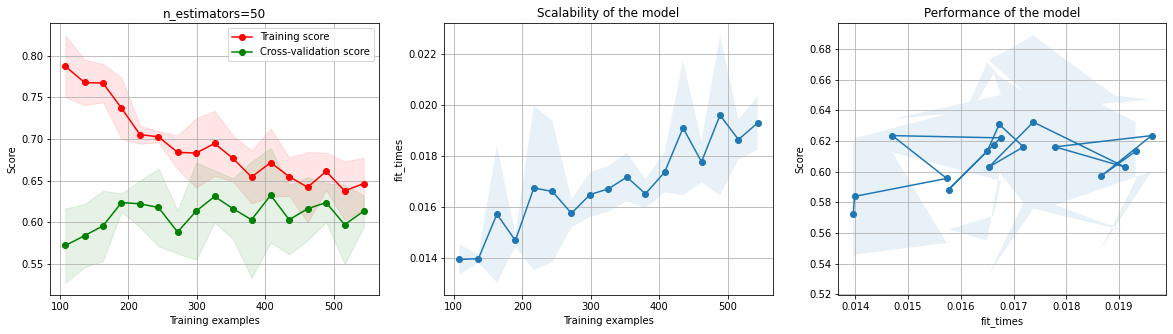

In [34]:
# Testing n_estimators = 5, 3, 10

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=13)
plot_learning_curve(estimator=model_RandomForest, title="Original: n_estimators=5", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=3, min_impurity_decrease=0.05, max_depth=13)
plot_learning_curve(estimator=model_RandomForest, title="n_estimators=20", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=8, min_impurity_decrease=0.05, max_depth=13)
plot_learning_curve(estimator=model_RandomForest, title="n_estimators=50", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))




time: 1.26528
time: 1.34093
time: 1.15685


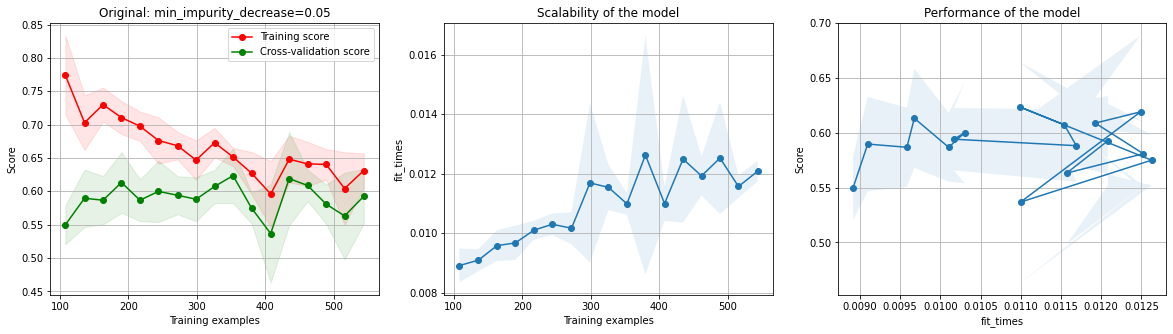

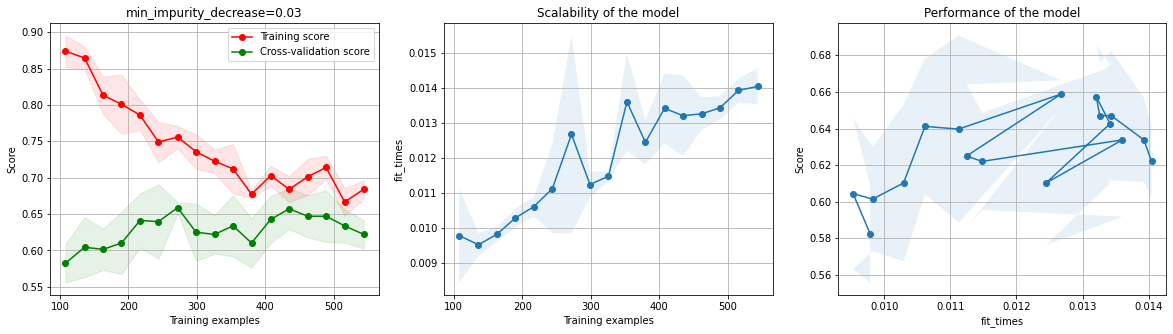

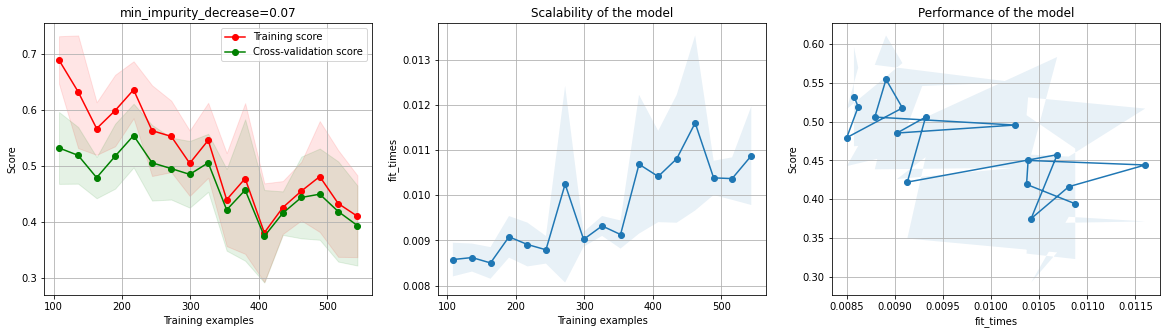

In [35]:
# Testing min_impurity_decrease = 0.05, 0.03, 0.07

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=13)
plot_learning_curve(estimator=model_RandomForest, title="Original: min_impurity_decrease=0.05", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.03, max_depth=13)
plot_learning_curve(estimator=model_RandomForest, title="min_impurity_decrease=0.03", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.07, max_depth=13)
plot_learning_curve(estimator=model_RandomForest, title="min_impurity_decrease=0.07", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))




time: 1.23507
time: 1.24098
time: 1.30034


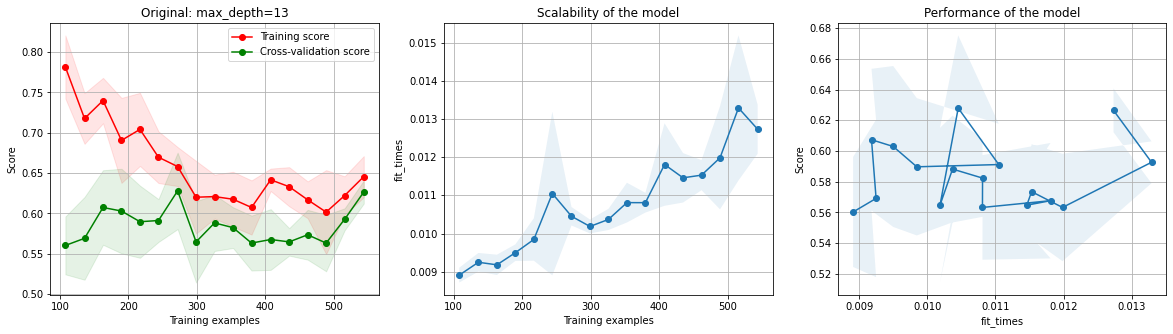

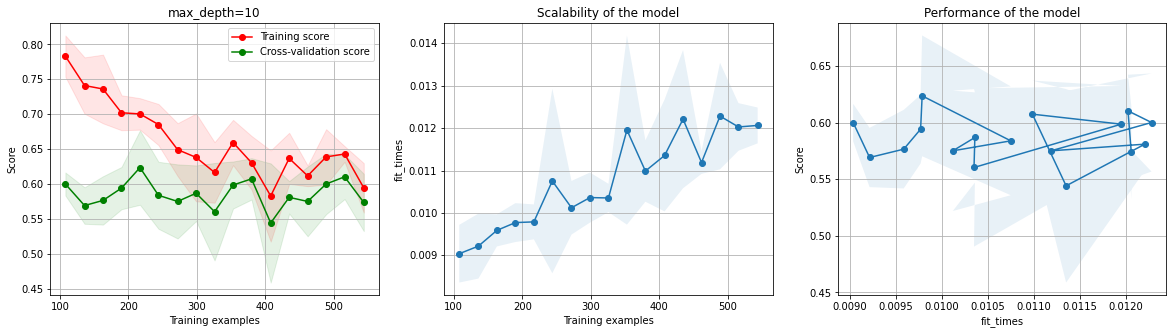

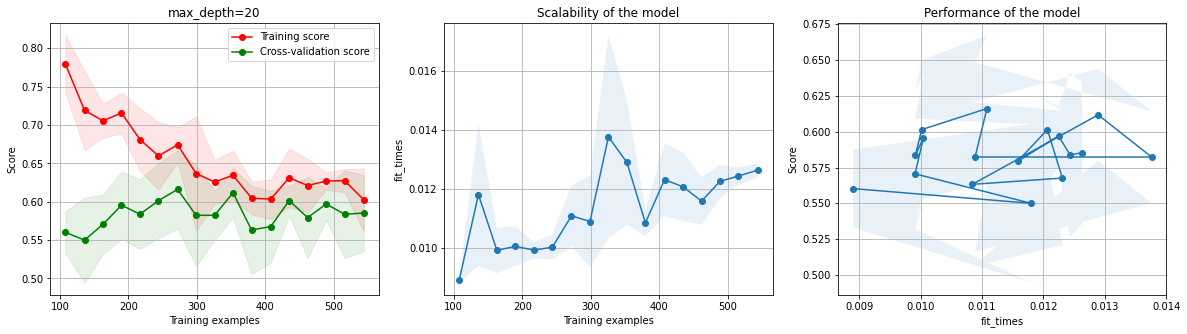

In [36]:
# Testing max_depth = 13, 10, 20

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=13)
plot_learning_curve(estimator=model_RandomForest, title="Original: max_depth=13", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=10)
plot_learning_curve(estimator=model_RandomForest, title="max_depth=10", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=20)
plot_learning_curve(estimator=model_RandomForest, title="max_depth=20", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))




In [37]:

model_Linear = linear_model.LogisticRegression(tol=1e-5)
model_Linear

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)

time: 1.23350
time: 1.13787


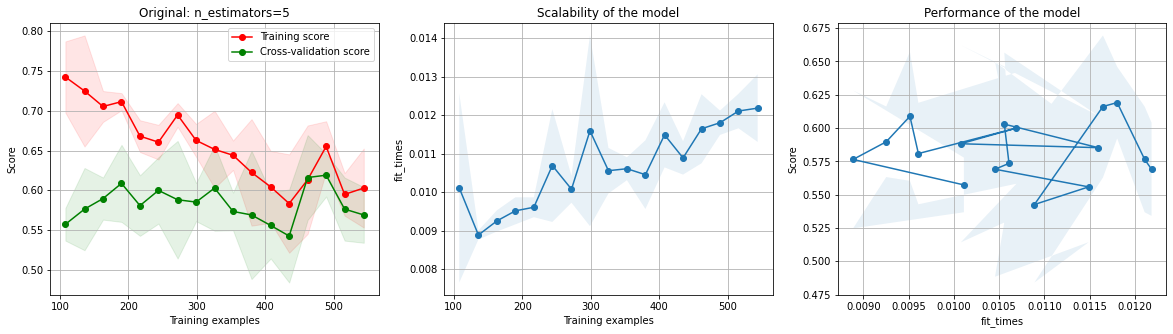

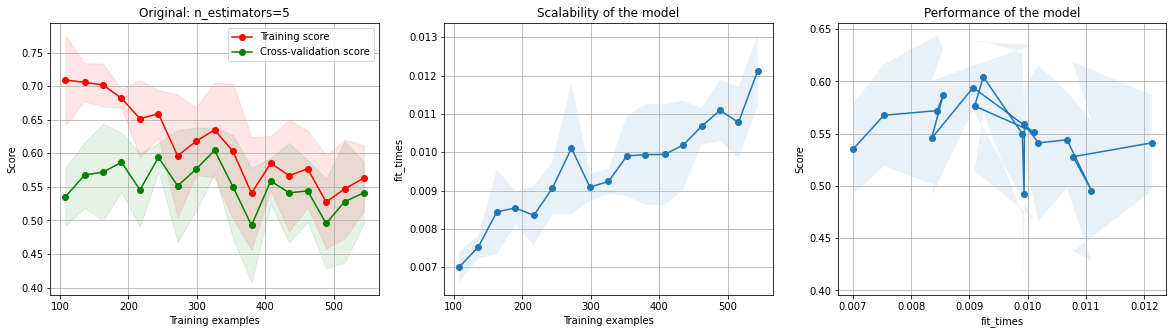

In [38]:
# Testing bootstrap
start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=13)
plot_learning_curve(estimator=model_RandomForest, title="Original: n_estimators=5", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_RandomForest = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=13, bootstrap=False)
plot_learning_curve(estimator=model_RandomForest, title="Original: n_estimators=5", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))



time: 2.66502
time: 2.74303
time: 2.73348


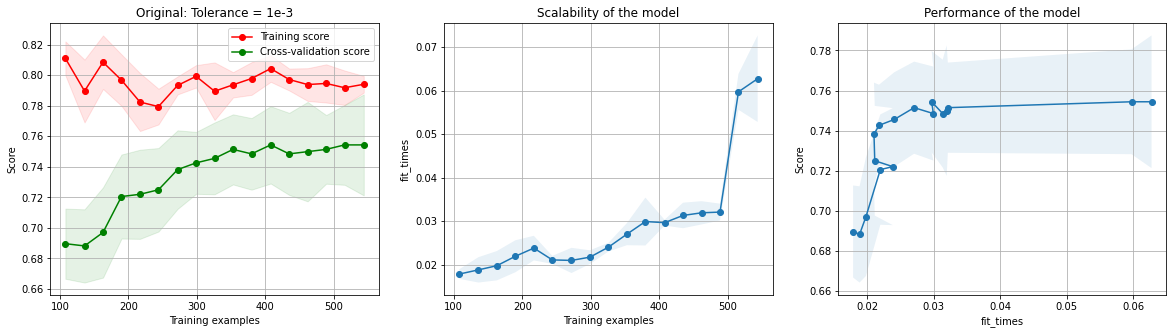

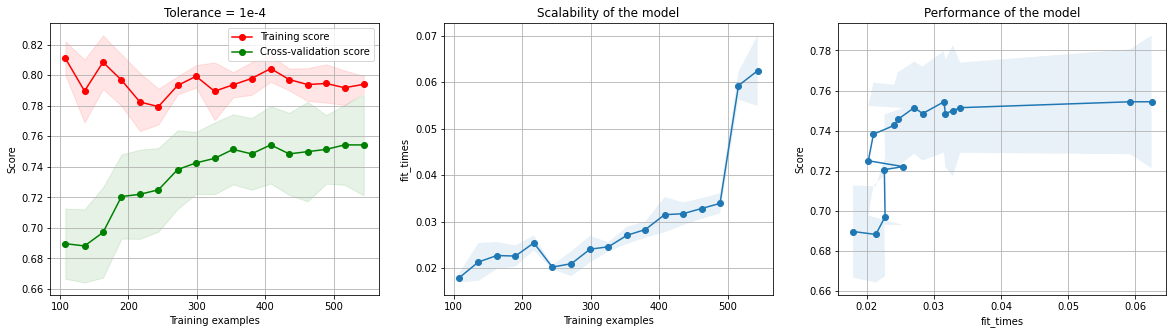

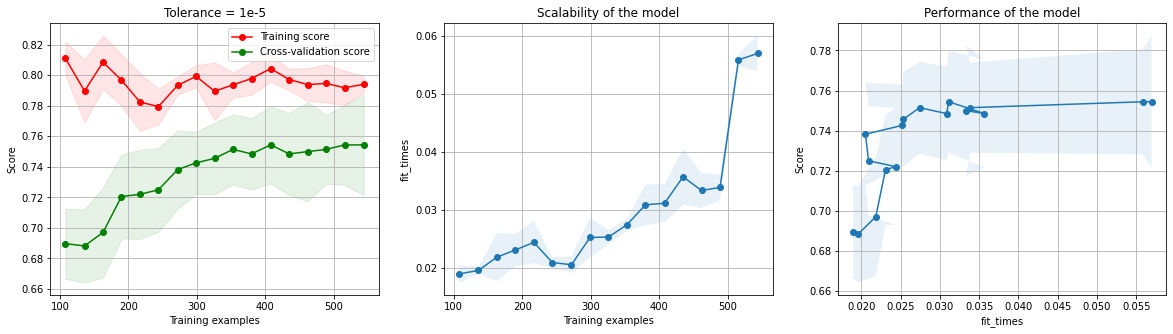

In [39]:
# Test 
start = time()
model_Logistic = linear_model.LogisticRegression(tol=1e-3)
plot_learning_curve(estimator=model_Logistic, title="Original: Tolerance = 1e-3", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_Logistic = linear_model.LogisticRegression(tol=1e-4)
plot_learning_curve(estimator=model_Logistic, title="Tolerance = 1e-4", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_Logistic = linear_model.LogisticRegression(tol=1e-5)
plot_learning_curve(estimator=model_Logistic, title="Tolerance = 1e-5", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))




time: 8.81776
time: 11.70807
time: 9.88979
time: 11.81473


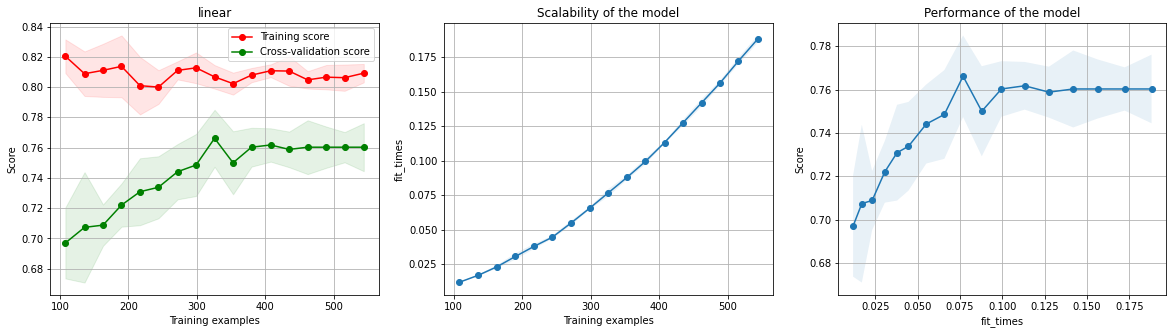

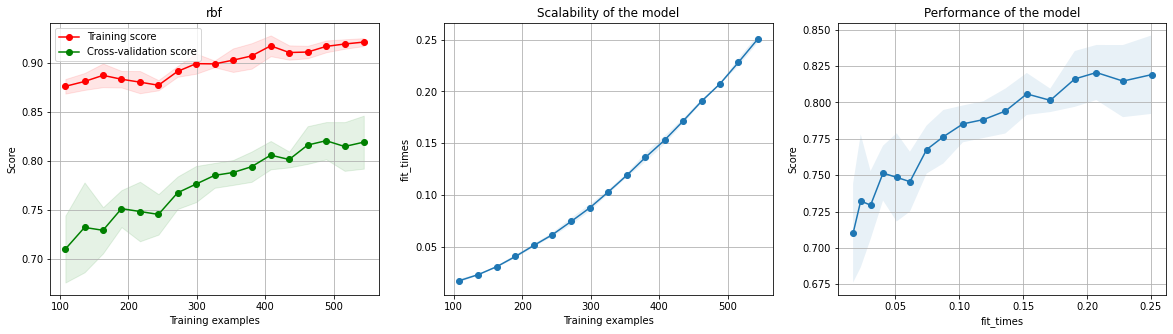

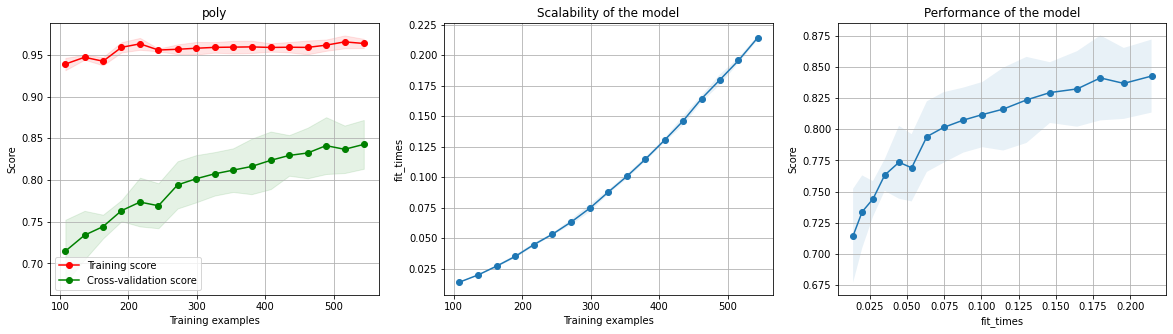

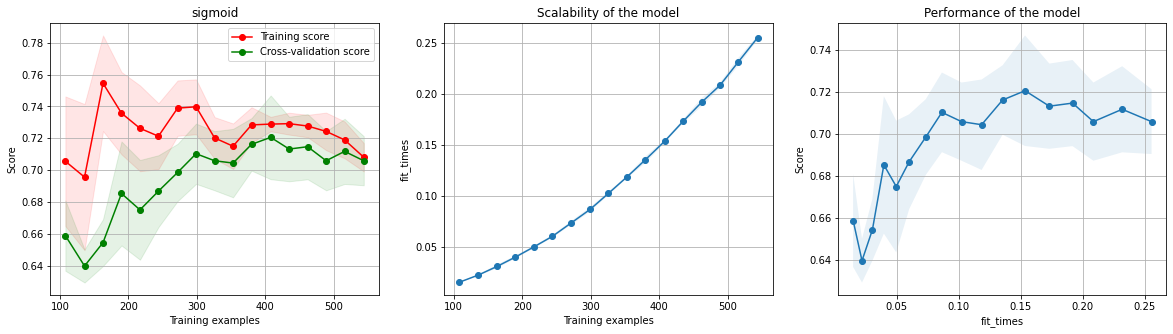

In [40]:

start = time()
model_SVC = SVC(kernel = 'linear', probability=True)
plot_learning_curve(estimator=model_SVC, title="linear", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_SVC = SVC(kernel = 'rbf', probability=True)
plot_learning_curve(estimator=model_SVC, title="rbf", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_SVC = SVC(kernel = 'poly', probability=True)
plot_learning_curve(estimator=model_SVC, title="poly", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))

start = time()
model_SVC = SVC(kernel = 'sigmoid', probability=True)
plot_learning_curve(estimator=model_SVC, title="sigmoid", X=X_train, y=y_train, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=train_sizes)
print("time: %.5f"%(time() - start))



In [41]:
data = load('aedl.npz')
X_val_faces = data['arr_2']
# print(X_val_faces[0])
# selection = choice([i for i in range(X_val.shape[0])])
model = ensemble.RandomForestClassifier(n_estimators=5, min_impurity_decrease=0.05, max_depth=13, bootstrap=False)
model.fit(X_train, y_train)
for selection in range (X_val.shape[0]):
  random_face_pixels = X_val_faces[selection]
  random_face_embedding = X_val[selection]
  # random_face_class = y_val[selection]
  # random_face_name = out_encoder.inverse_transform([random_face_class])

  samples = expand_dims(random_face_embedding, axis = 0)
  y_hat_class = model.predict(samples)
  y_hat_prob = model.predict_proba(samples)
  class_index = y_hat_class[0]
  class_probability = y_hat_prob[0, class_index]
  predict_names = out_encoder.inverse_transform(y_hat_class)
  print('Predicted:')
  #  %s (%3f)'%(predict_names[0], class_probability))
  plt.imshow(random_face_pixels)
  title = '%s (%.3f)'%(predict_names[0], class_probability)
  plt.title(title)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [42]:
test_folder = 'Test/'
X_test = list()
X_test.extend(load_faces(test_folder))
X_test = asarray(X_test)
X_test_faces = X_test
print(X_test.shape)

X_test_new = list()
for face_pixels in X_test:
  embedding = do_embedding(face_pixels, model_facenet)
  X_test_new.append(embedding)

X_test = asarray(X_test_new)
X_test = in_encoder.transform(X_test)

print(X_test)

(82, 160, 160, 3)
[[ 0.10017655 -0.06892619 -0.14556246 ... -0.1546008  -0.07432035
  -0.04396146]
 [ 0.10456305 -0.05319577 -0.13593815 ... -0.14972067 -0.07744811
  -0.06099329]
 [ 0.11285792 -0.05726371 -0.1321403  ... -0.16023345 -0.08482884
  -0.05232894]
 ...
 [-0.16421157 -0.19331078  0.07107209 ... -0.06058603  0.1739547
   0.15666474]
 [-0.174883   -0.24129309 -0.02722785 ... -0.08183657  0.20547381
   0.13551551]
 [ 0.01732138 -0.05330183  0.05201402 ...  0.05162201  0.03776493
   0.06920815]]


In [43]:
for i in range (X_test.shape[0]):
  face_pixels = X_test_faces[i]
  face_embedding = X_test[i]

  samples = expand_dims(face_embedding, axis = 0)
  y_hat_class = model.predict(samples)
  y_hat_prob = model.predict_proba(samples)

  class_index = y_hat_class[0]
  class_probability = y_hat_prob[0, class_index]
  # print(class_probability)

  predict_names = out_encoder.inverse_transform(y_hat_class)

  if class_probability < 0.65:
    print(print('Predicted: unknown. Closest prediction: %s (%3f)'%(predict_names[0], class_probability)))
    title = 'Unknown'
  else:
    print('Predicted: ')
    #  %s (%3f)'%(predict_names[0], class_probability))
    title = '%s (%.3f)'%(predict_names[0], class_probability)
  # print('Expected: %s'%random_face_name[0])
  plt.imshow(face_pixels)
  # title = '%s (%.3f)'%(predict_names[0], class_probability)
  plt.title(title)
  plt.show()
    

Output hidden; open in https://colab.research.google.com to view.

In [44]:
!nvidia-smi

Thu Jul  8 16:36:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    73W / 149W |   8254MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        2.4G        5.4G         15M        4.9G         10G
Swap:            0B          0B          0B


In [ ]:
!free --help


Usage:
 free [options]

Options:
 -b, --bytes         show output in bytes
     --kilo          show output in kilobytes
     --mega          show output in megabytes
     --giga          show output in gigabytes
     --tera          show output in terabytes
     --peta          show output in petabytes
 -k, --kibi          show output in kibibytes
 -m, --mebi          show output in mebibytes
 -g, --gibi          show output in gibibytes
     --tebi          show output in tebibytes
     --pebi          show output in pebibytes
 -h, --human         show human-readable output
     --si            use powers of 1000 not 1024
 -l, --lohi          show detailed low and high memory statistics
 -t, --total         show total for RAM + swap
 -s N, --seconds N   repeat printing every N seconds
 -c N, --count N     repeat printing N times, then exit
 -w, --wide          wide output

     --help     display this help and exit
 -V, --version  output version information and exit

For more detail